In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
# load image data 
import os
import numpy as np
import h5py
import cv2 as cv
resized_path = "../data/prepare/resized"

def load_img(image_name):
    file_path = os.path.join(resized_path, image_name)
    img = cv.imread(file_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img_rgb

images = [ load_img(name) for name in os.listdir(resized_path)]
print(images[0].shape)

# Normalize pixel values to be between 0 and 1
images_mat = np.asarray(images)
images_mat = images_mat / 255.0
print(images_mat[0])
images_mat.shape


# load embedding data
h5f = h5py.File('../data/eigenface_embeds.h5','r')
train_embeds = np.copy(h5f['embeds'])
print(train_embeds[0].shape)
h5f.close()


(120, 90, 3)
[[[0.3372549  0.24313725 0.13333333]
  [0.34901961 0.25490196 0.14509804]
  [0.36862745 0.2627451  0.15686275]
  ...
  [0.26666667 0.18039216 0.1372549 ]
  [0.24313725 0.16470588 0.1372549 ]
  [0.23921569 0.16470588 0.1372549 ]]

 [[0.33333333 0.23137255 0.1254902 ]
  [0.34117647 0.23921569 0.13333333]
  [0.35686275 0.25098039 0.14509804]
  ...
  [0.27843137 0.18431373 0.14509804]
  [0.25490196 0.17647059 0.14117647]
  [0.25490196 0.18039216 0.15294118]]

 [[0.3254902  0.21960784 0.11372549]
  [0.3372549  0.23137255 0.1254902 ]
  [0.35686275 0.23921569 0.12941176]
  ...
  [0.29411765 0.2        0.16078431]
  [0.28235294 0.19215686 0.16078431]
  [0.27843137 0.2        0.16470588]]

 ...

 [[0.66666667 0.69019608 0.75294118]
  [0.66666667 0.69019608 0.74509804]
  [0.61960784 0.64313725 0.69803922]
  ...
  [0.34901961 0.35294118 0.33333333]
  [0.39215686 0.39215686 0.38431373]
  [0.39607843 0.40392157 0.39215686]]

 [[0.67058824 0.69803922 0.76862745]
  [0.67058824 0.69803922

In [3]:
# Keras model

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(120, 90, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 90, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(384))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 88, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 44, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 42, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 21, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 19, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 31616)            

In [4]:
loss = tf.keras.losses.MeanSquaredLogarithmicError()
# opt = tf.keras.optimizers.AdamW(
#     learning_rate=0.001,
#     weight_decay=0.004,
# )

opt = tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

model.compile(
    optimizer=opt, loss=loss
)

train_imgs = images_mat
history = model.fit(
    train_imgs, train_embeds, 
    batch_size=5,
    epochs=50, 
    # Suppress logging.
    # verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.5,
)


c:\anaconda\envs\py39\lib\site-packages\keras\src\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50

575/575 [==============================] - 10s 17ms/step - loss: 0.1594 - val_loss: 0.1533
Epoch 2/50
575/575 [==============================] - 9s 16ms/step - loss: 0.1527 - val_loss: 0.1499
Epoch 3/50
575/575 [==============================] - 9s 16ms/step - loss: 0.1503 - val_loss: 0.1484
Epoch 4/50
575/575 [==============================] - 9s 16ms/step - loss: 0.1491 - val_loss: 0.1472
Epoch 5/50
575/575 [==============================] - 9s 16ms/step - loss: 0.1475 - val_loss: 0.1458
Epoch 6/50
575/575 [==============================] - 9s 16ms/step - loss: 0.1466 - val_loss: 0.1451
Epoch 7/50
575/575 [==============================] - 9s 16ms/step - loss: 0.1460 - val_loss: 0.1446
Epoch 8/50
575/575 [==============================] - 9s 16ms/step - loss: 0.1456 - val_loss: 0.1443
Epoch 9/50
575/575 [==============================] - 9s 16ms/step - loss: 0.1454 - val_loss: 0.1442
Epoch 10/50
575/575 [==============================] - 9s 16ms/step - loss: 0.1453 - val_

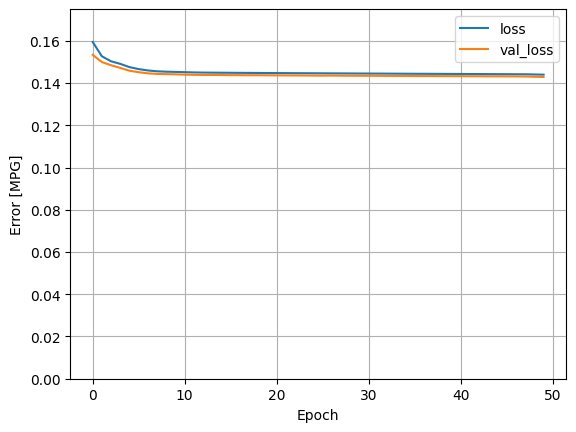

In [7]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 0.175])
    plt.xlabel("Epoch")
    plt.ylabel("Error [MPG]")
    plt.legend()
    plt.grid(True)


plot_loss(history)


In [13]:
model.predict(train_imgs[0])


ValueError: in user code:

    File "c:\anaconda\envs\py39\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\anaconda\envs\py39\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\anaconda\envs\py39\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\anaconda\envs\py39\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\anaconda\envs\py39\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\anaconda\envs\py39\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 120, 90, 3), found shape=(None, 90, 3)
